In [1]:
!pip install matplotlib seaborn


  Using cached matplotlib-3.10.5-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
Using cached matplotlib-3.10.5-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (362 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 2.1 MB/s eta 0:00:00a 0:00:01
Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (1.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [seaborn]

Dataset Shape: (1000, 21)

First few rows:
  Year Current Course         Technical Skill Programming Languages  \
0  4th     B.Tech CSE        IoT Applications     Java Kotlin Swift   
1  3rd      B.Tech IT        Data Engineering  PHP JavaScript MySQL   
2  4th      B.Tech IT    Cloud Infrastructure        Julia Python R   
3  3rd      B.Tech IT  Full Stack Development       Python Java C++   
4  3rd            MCA         Computer Vision          Python R SQL   

   Rating(technical and programming) Projects    Career Interest  \
0                                  3       No    Cloud Architect   
1                                  5       No     Data Scientist   
2                                  2      Yes    Cloud Architect   
3                                  4      Yes  Software Engineer   
4                                  4       No     Data Scientist   

            Challenges     Support-required  Student-Linguistic  ...  Bodily  \
0    Lack of resources  Mentorship progra

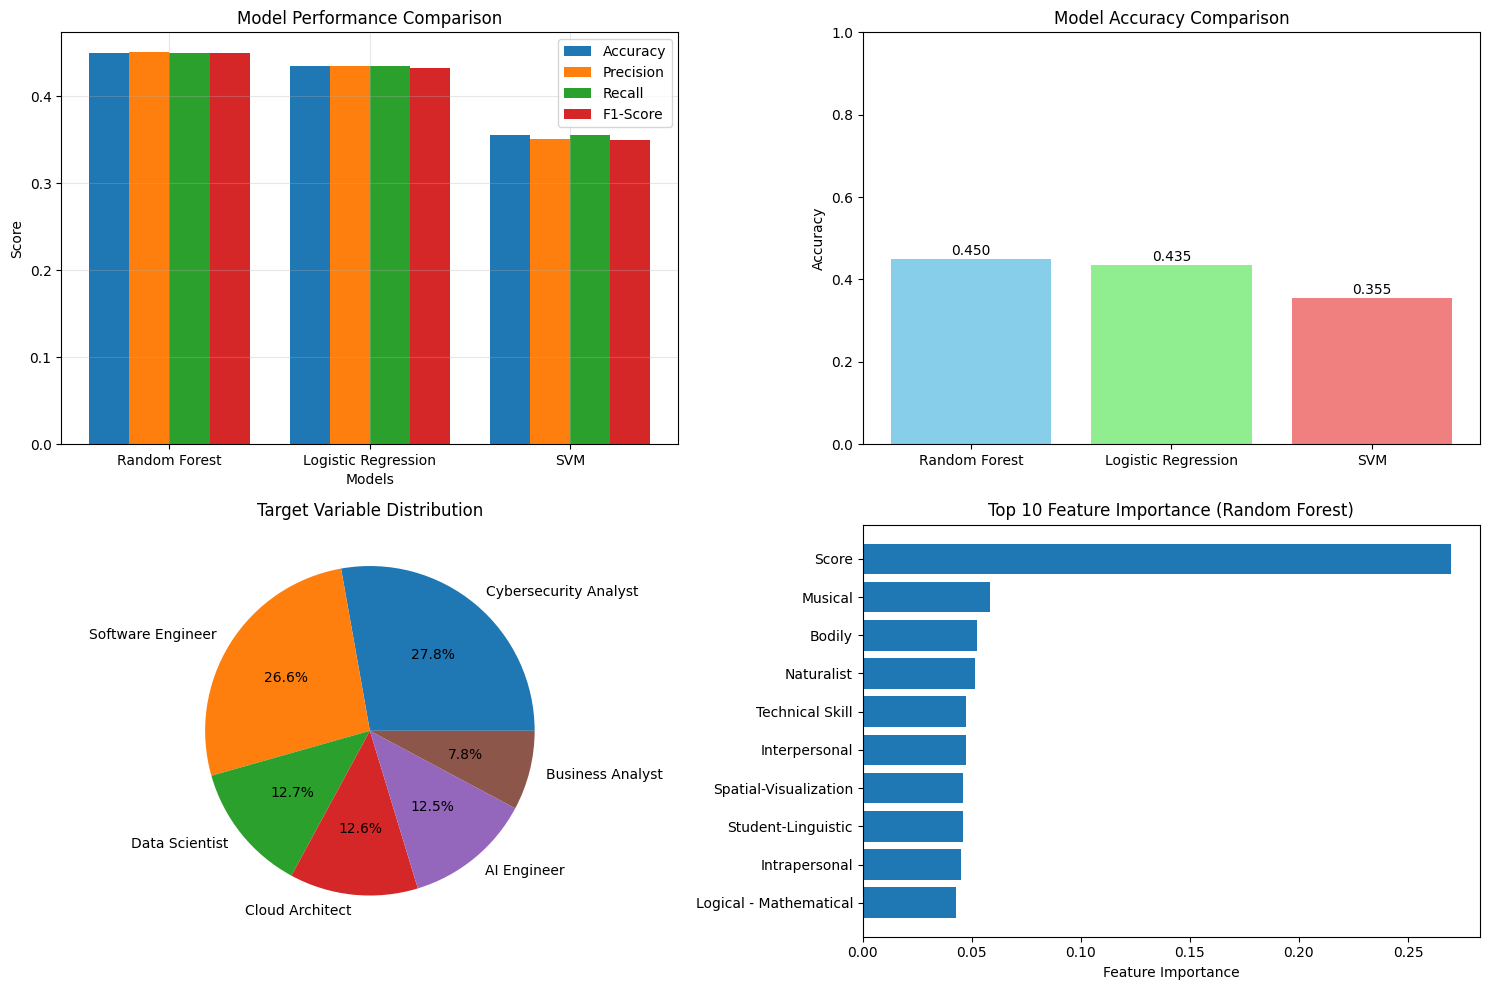


BEST PERFORMING MODEL: Random Forest
Best Accuracy: 0.4500


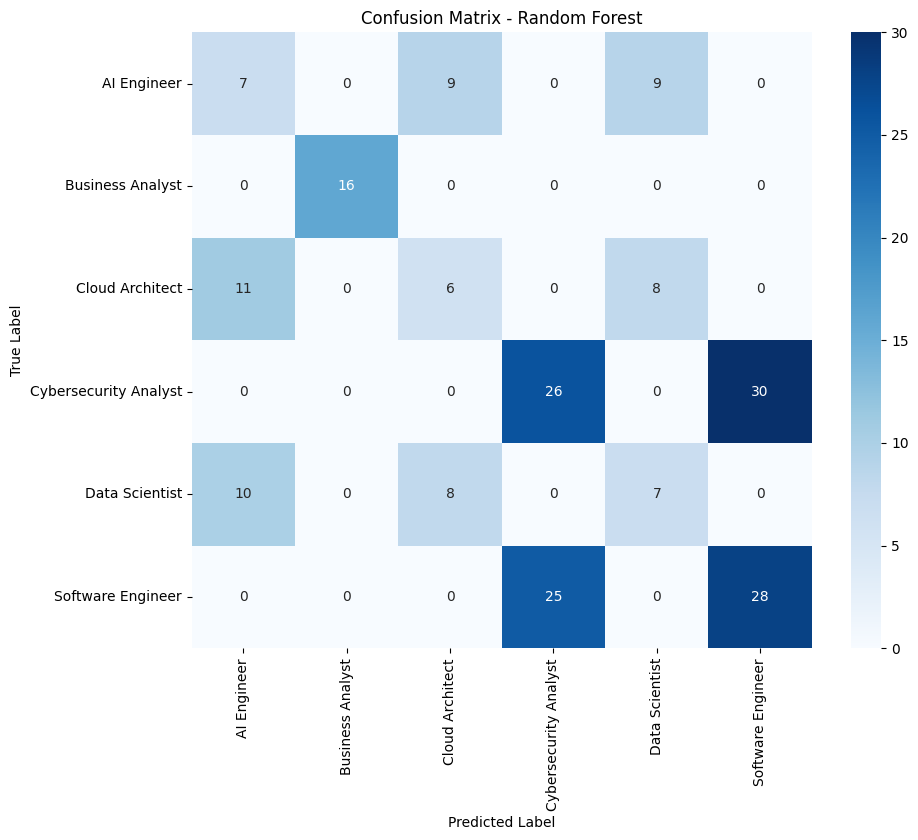

NameError: name 'os' is not defined

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# Note: Ensure the CSV file exists at this path.
# If you are running this after the export script, you might want to use 'Data/csv_sheets/DMA.csv'
df = pd.read_csv('Data/synthetic_student_career_data_1000.csv')


print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nTarget Variable Distribution:")
print(df['Recommended Job'].value_counts())

# Phase 1: Data Preprocessing and Baseline Model

# 1. Data Preprocessing
def preprocess_data(df):
    """
    Preprocesses the data by handling the 'Year' column and encoding other categoricals.
    """
    # Create a copy of the dataframe
    data = df.copy()

    # --- [FIX] Handle the 'Year' column by converting it to a numeric format ---
    if 'Year' in data.columns:
        # Clean the column by stripping whitespace and making it lowercase
        year_col = data['Year'].astype(str).str.lower().str.strip()

        # Define a mapping for year values
        year_map = {
            '1st': 1,
            '2nd': 2,
            '3rd': 3,
            'final': 4
        }

        # Apply the mapping based on the first word found (handles '1st Year', '2nd', etc.)
        # .fillna(0) handles any values that don't match the map.
        data['Year'] = year_col.str.split().str[0].map(year_map).fillna(0).astype(int)
        print("\n[INFO] 'Year' column has been converted to a numeric format.")

    # Encode other categorical variables
    categorical_columns = ['Current Course', 'Technical Skill', 'Programming Languages',
                          'Projects', 'Career Interest', 'Challenges', 'Support-required',
                          'Soft Skills']

    label_encoders = {}
    for col in categorical_columns:
        if col in data.columns:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col].astype(str))
            label_encoders[col] = le

    # Features and target
    target_column = 'Recommended Job'
    feature_columns = [col for col in data.columns if col != target_column]

    X = data[feature_columns]
    y = data[target_column]

    # Encode target variable
    target_encoder = LabelEncoder()
    y_encoded = target_encoder.fit_transform(y)

    return X, y_encoded, target_encoder, label_encoders

# Preprocess the data
X, y, target_encoder, label_encoders = preprocess_data(df)

print("\nFeature columns:")
print(X.columns.tolist())
print(f"\nFeatures shape: {X.shape}")
print(f"Target classes: {len(np.unique(y))}")

# 2. Data Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData Split:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")

# 3. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Baseline Models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, kernel='rbf')
}

# 5. Model Training and Evaluation
results = {}

for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")

    # Train the model
    if model_name == 'Random Forest':
        # Random Forest doesn't strictly require scaling, but it's good practice to use consistent data
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        # Use scaled features for other models
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    # Print model summary
    print(f"\nModel: {model_name}")
    print(f"Parameters: {model.get_params()}")

    # Print metrics
    print(f"\nMetric Values:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Detailed classification report
    print(f"\nDetailed Classification Report:")
    target_names = target_encoder.classes_
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# 6. Results Summary Table
print(f"\n{'='*60}")
print("BASELINE MODEL RESULTS SUMMARY")
print(f"{'='*60}")

results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print(results_df)

# 7. Visualization of Results
plt.figure(figsize=(15, 10))

# Plot 1: Model Comparison
plt.subplot(2, 2, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(models))
width = 0.2

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in models.keys()]
    plt.bar(x + i*width, values, width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width*1.5, models.keys())
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy Comparison
plt.subplot(2, 2, 2)
accuracies = [results[model]['Accuracy'] for model in models.keys()]
plt.bar(models.keys(), accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

# Plot 3: Target Distribution
plt.subplot(2, 2, 3)
target_counts = pd.Series(y).value_counts()
target_labels = [target_encoder.classes_[i] for i in target_counts.index]
plt.pie(target_counts.values, labels=target_labels, autopct='%1.1f%%')
plt.title('Target Variable Distribution')

# Plot 4: Feature Importance (for Random Forest)
plt.subplot(2, 2, 4)
rf_model = models['Random Forest']
feature_importance = rf_model.feature_importances_
feature_names = X.columns
top_10_indices = np.argsort(feature_importance)[-10:]
plt.barh(range(len(top_10_indices)), feature_importance[top_10_indices])
plt.yticks(range(len(top_10_indices)), [feature_names[i] for i in top_10_indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importance (Random Forest)')

plt.tight_layout()
plt.show()

# 8. Best Model Analysis
best_model_name = max(results.keys(), key=lambda x: results[x]['Accuracy'])
best_model = models[best_model_name]

print(f"\n{'='*50}")
print(f"BEST PERFORMING MODEL: {best_model_name}")
print(f"{'='*50}")
print(f"Best Accuracy: {results[best_model_name]['Accuracy']:.4f}")

# Confusion Matrix for best model
if best_model_name == 'Random Forest':
    y_pred_best = best_model.predict(X_test_scaled) # Use scaled data for consistency
else:
    y_pred_best = best_model.predict(X_test_scaled)


plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 9. Save Results
os.makedirs('Data/results', exist_ok=True)
results_df.to_csv('Data/results/baseline_model_results.csv')
print(f"\nResults saved to 'Data/results/baseline_model_results.csv'")

print(f"\n{'='*60}")
print("PHASE 1 BASELINE MODEL ANALYSIS COMPLETE")
print(f"{'='*60}")

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

def phase_2_data_preprocessing():
    """
    Phase 2: Data Preprocessing and Feature Engineering
    This phase includes data cleaning, encoding, feature scaling, and dataset splitting
    """

    # Load the dataset
    df = pd.read_csv('Data/synthetic_student_career_data_1000.csv')

    print("=== PHASE 2: DATA PREPROCESSING ===")
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # 1. DATA INSPECTION
    print("\n1. Data Inspection:")
    print("Missing values per column:")
    print(df.isnull().sum())

    print("\nData types:")
    print(df.dtypes)

    # 2. CATEGORICAL ENCODING
    print("\n2. Encoding Categorical Variables:")

    # Create a copy for processing
    processed_df = df.copy()

    # Define categorical columns
    categorical_cols = [
        'Year', 'Current Course', 'Technical Skill', 'Programming Languages',
        'Projects', 'Career Interest', 'Challenges', 'Support-required',
        'Soft Skills', 'Recommended Job'
    ]

    # Initialize label encoders
    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()
        processed_df[col + '_encoded'] = le.fit_transform(processed_df[col])
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} unique categories")

    # 3. FEATURE SELECTION AND PREPARATION
    print("\n3. Feature Engineering:")

    # Create numerical features list
    numerical_features = [
        'Rating(technical and programming)', 'Student-Linguistic', 'Musical',
        'Bodily', 'Logical - Mathematical', 'Spatial-Visualization',
        'Interpersonal', 'Intrapersonal', 'Naturalist', 'Rating(soft skills)', 'Score'
    ]

    # Create encoded categorical features list
    encoded_categorical_features = [col + '_encoded' for col in categorical_cols if col != 'Recommended Job']

    # Combine all features
    feature_columns = numerical_features + encoded_categorical_features

    # Prepare features and target
    X = processed_df[feature_columns]
    y = processed_df['Recommended Job_encoded']

    print(f"Total features: {X.shape[1]}")
    print(f"Feature columns: {feature_columns}")

    # 4. FEATURE SCALING
    print("\n4. Feature Scaling:")

    # Scale numerical features
    scaler = StandardScaler()
    X_scaled = X.copy()
    X_scaled[numerical_features] = scaler.fit_transform(X[numerical_features])

    print("Applied StandardScaler to numerical features")

    # 5. TRAIN-TEST SPLIT
    print("\n5. Dataset Splitting:")

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Target classes: {len(np.unique(y))}")

    # 6. DATA SUMMARY STATISTICS
    print("\n6. Summary Statistics:")
    print("Training set statistics:")
    print(X_train.describe())

    # 7. SAVE PROCESSED DATA
    print("\n7. Saving Processed Data:")

    # Save processed datasets
    X_train.to_csv('X_train_processed.csv', index=False)
    X_test.to_csv('X_test_processed.csv', index=False)
    pd.DataFrame(y_train).to_csv('Data/y_train.csv', index=False)
    pd.DataFrame(y_test).to_csv('Data/y_test.csv', index=False)

    print("Processed datasets saved to CSV files")

    # Return all necessary components
    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'feature_columns': feature_columns,
        'label_encoders': label_encoders,
        'scaler': scaler,
        'processed_df': processed_df
    }

def analyze_target_distribution(y_train, y_test, label_encoders):
    """
    Analyze the distribution of target variable
    """
    print("\n=== TARGET DISTRIBUTION ANALYSIS ===")

    # Get job labels
    job_encoder = label_encoders['Recommended Job']
    job_labels = job_encoder.classes_

    # Training set distribution
    train_counts = pd.Series(y_train).value_counts().sort_index()
    test_counts = pd.Series(y_test).value_counts().sort_index()

    print("Job Distribution in Training Set:")
    for i, count in train_counts.items():
        print(f"{job_labels[i]}: {count} ({count/len(y_train)*100:.1f}%)")

    print("\nJob Distribution in Test Set:")
    for i, count in test_counts.items():
        print(f"{job_labels[i]}: {count} ({count/len(y_test)*100:.1f}%)")

def create_correlation_analysis(X_train, feature_columns):
    """
    Perform correlation analysis on features
    """
    print("\n=== CORRELATION ANALYSIS ===")

    # Calculate correlation matrix
    correlation_matrix = X_train.corr()

    # Find highly correlated features
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.7:  # High correlation threshold
                high_corr_pairs.append((
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j],
                    corr_value
                ))

    print("Highly correlated feature pairs (|correlation| > 0.7):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1} <-> {feat2}: {corr:.3f}")

    return correlation_matrix

# Execute Phase 2
if __name__ == "__main__":
    # Run Phase 2 preprocessing
    phase_2_results = phase_2_data_preprocessing()

    # Analyze target distribution
    analyze_target_distribution(
        phase_2_results['y_train'],
        phase_2_results['y_test'],
        phase_2_results['label_encoders']
    )

    # Perform correlation analysis
    correlation_matrix = create_correlation_analysis(
        phase_2_results['X_train'],
        phase_2_results['feature_columns']
    )

    print("\n=== PHASE 2 COMPLETED SUCCESSFULLY ===")
    print("Ready for Phase 3: Model Training and Evaluation")


=== PHASE 2: DATA PREPROCESSING ===
Dataset shape: (1000, 21)
Columns: ['Year', 'Current Course', 'Technical Skill', 'Programming Languages', 'Rating(technical and programming)', 'Projects', 'Career Interest', 'Challenges', 'Support-required', 'Student-Linguistic', 'Musical', 'Bodily', 'Logical - Mathematical', 'Spatial-Visualization', 'Interpersonal', 'Intrapersonal', 'Naturalist', 'Soft Skills', 'Rating(soft skills)', 'Score', 'Recommended Job']

1. Data Inspection:
Missing values per column:
Year                                 0
Current Course                       0
Technical Skill                      0
Programming Languages                0
Rating(technical and programming)    0
Projects                             0
Career Interest                      0
Challenges                           0
Support-required                     0
Student-Linguistic                   0
Musical                              0
Bodily                               0
Logical - Mathematical          

=== PHASE 3: ADVANCED MODEL TRAINING AND HYPERPARAMETER TUNING ===
✅ Successfully loaded processed data from Phase 2.

--- Tuning Random Forest ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Best Params for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score for Random Forest: 0.4800

--- Tuning Gradient Boosting ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best CV Score for Gradient Boosting: 0.4713

--- Tuning XGBoost ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params for XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best CV Score for XGBoost: 0.4838

=== FINAL MODEL EVALUATION ON TEST SET ===

----- Random Forest -----
Test Accuracy: 0.4500
Classification Report:
                       precision    recall  f1-score   support

          AI Engineer       0.31      0.44      0.37        25
     Business Analyst       1.00      1.00      1.00        16
      Cloud Architect       0.46      0.44      0.45        25
Cybersecurity Analyst       0.47      0.48      0.47        

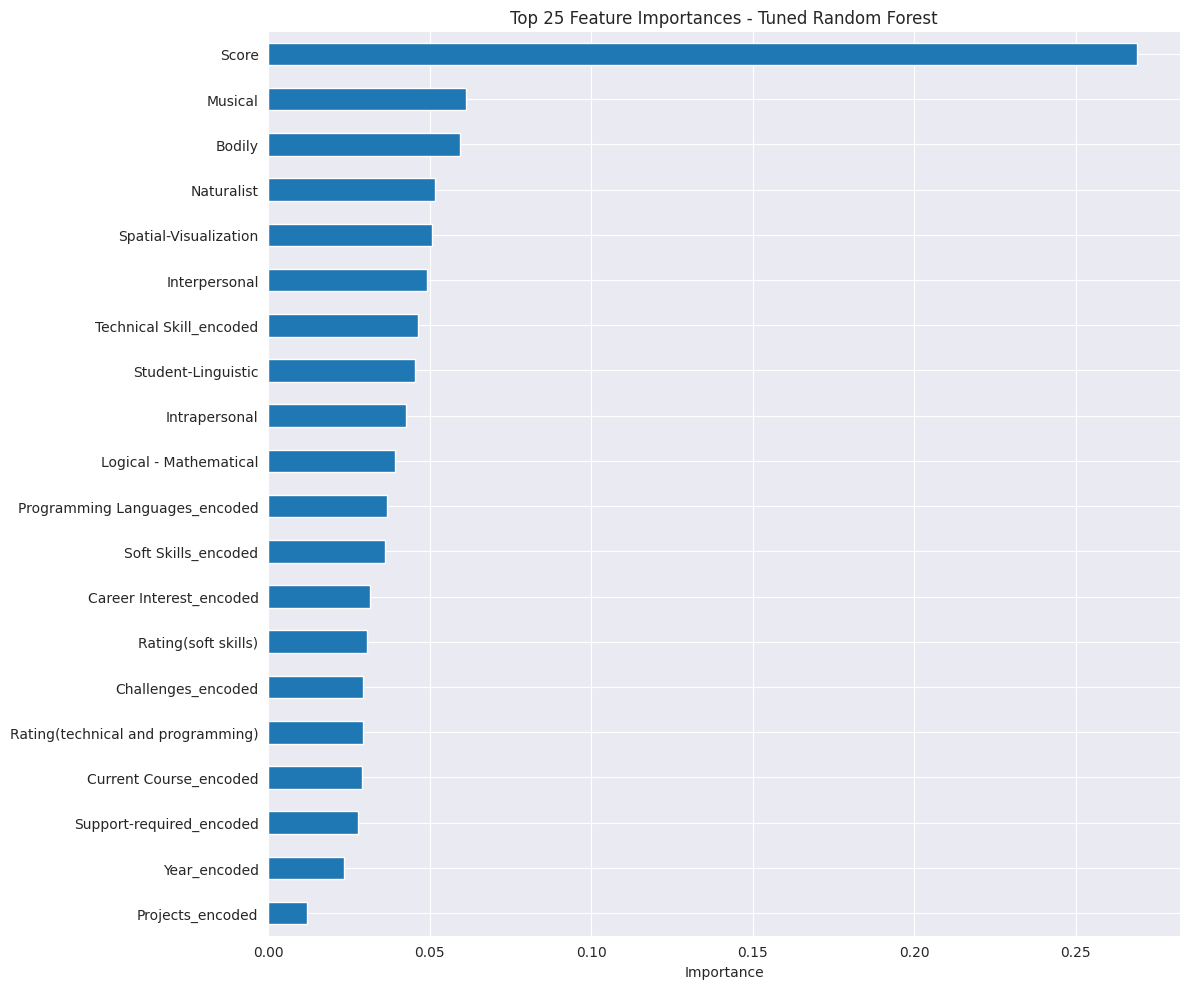


=== PHASE 3 COMPLETED SUCCESSFULLY ===


In [5]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# This cell assumes the previous cell (Phase 2) has been run and
# the 'phase_2_results' dictionary is available in memory.

print("=== PHASE 3: ADVANCED MODEL TRAINING AND HYPERPARAMETER TUNING ===")

# 1. Unpack the processed data from the previous phase
try:
    X_train = phase_2_results['X_train']
    X_test = phase_2_results['X_test']
    y_train = phase_2_results['y_train']
    y_test = phase_2_results['y_test']
    feature_columns = phase_2_results['feature_columns']
    target_encoder = phase_2_results['label_encoders']['Recommended Job']
    print("✅ Successfully loaded processed data from Phase 2.")
except NameError:
    print("❌ Error: 'phase_2_results' not found. Please run the 'Phase 2' cell before this one.")
    # Stop execution if the data isn't loaded
    raise

# 2. Initialize models
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
gbm = GradientBoostingClassifier(random_state=42)
# Note: XGBoost is often not installed by default. If you get an error, run: !pip install xgboost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 3. Define a smaller, more focused hyperparameter grid for efficient tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}
gbm_params = {
    'n_estimators': [100, 150],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5]
}
xgb_params = {
    'n_estimators': [100, 150],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5]
}

# 4. Set up GridSearchCV for each model
# Using cv=3 for faster cross-validation
models_to_tune = {
    'Random Forest': (rf, rf_params),
    'Gradient Boosting': (gbm, gbm_params),
    'XGBoost': (xgb, xgb_params)
}

best_models = {}

for name, (model, params) in models_to_tune.items():
    print(f"\n--- Tuning {name} ---")
    grid_search = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_models[name] = grid_search.best_estimator_
    print(f"Best Params for {name}: {grid_search.best_params_}")
    print(f"Best CV Score for {name}: {grid_search.best_score_:.4f}")


# 5. Evaluate the best models on the test set
print("\n=== FINAL MODEL EVALUATION ON TEST SET ===")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\n----- {name} -----")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_encoder.classes_, zero_division=0))


# 6. Visualize feature importance for the best overall model
# Let's assume Random Forest is a strong candidate for interpretation
best_rf_model = best_models['Random Forest']
importances = best_rf_model.feature_importances_

# Create a pandas series for easier plotting
feat_importances = pd.Series(importances, index=feature_columns)

plt.figure(figsize=(12, 10))
feat_importances.nlargest(25).plot(kind='barh')
plt.title("Top 25 Feature Importances - Tuned Random Forest")
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.tight_layout()
plt.show()

print("\n=== PHASE 3 COMPLETED SUCCESSFULLY ===")


In [6]:
import os
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score

# This cell assumes the 'phase_2_results' and 'best_models' dictionaries
# from the previous cells are available in memory.

print("=== PHASE 4: FINAL MODEL SELECTION & EXPORT FOR DEPLOYMENT ===")

# 1. Evaluate Final Tuned Models on the Test Set
final_results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    final_results[name] = {'Test Accuracy': accuracy}
    print(f"'{name}' Test Accuracy: {accuracy:.4f}")

# Create a summary DataFrame
results_df = pd.DataFrame(final_results).T.sort_values(by='Test Accuracy', ascending=False)

print("\n--- Final Model Performance Summary ---")
print(results_df)


# 2. Justification and Selection of the Best Model
# We will select the model with the highest accuracy on the test set.
best_model_name = results_df.index[0]
best_model_accuracy = results_df.iloc[0]['Test Accuracy']
final_model = best_models[best_model_name]

print(f"\n--- Model Selection Justification ---")
print(f"✅ Best Model Selected: '{best_model_name}'")
print(f"Justification: This model achieved the highest accuracy ({best_model_accuracy:.4f}) on the unseen test data after hyperparameter tuning.")
print("It demonstrates the best generalization performance among the candidates.")


# 3. Export Final Model and Preprocessing Artifacts for the App
# This is the most critical step for deployment.
export_dir = 'models'
os.makedirs(export_dir, exist_ok=True)

# Define file paths
model_path = os.path.join(export_dir, 'final_model.pkl')
scaler_path = os.path.join(export_dir, 'scaler.pkl')
target_encoder_path = os.path.join(export_dir, 'target_encoder.pkl')
feature_columns_path = os.path.join(export_dir, 'feature_columns.pkl')


# Save the artifacts using joblib
joblib.dump(final_model, model_path)
print(f"\n✅ Final model saved to: {model_path}")

# We also need to save the scaler and encoders to process new data in the app
scaler = phase_2_results['scaler']
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to: {scaler_path}")

target_encoder = phase_2_results['label_encoders']['Recommended Job']
joblib.dump(target_encoder, target_encoder_path)
print(f"✅ Target Encoder saved to: {target_encoder_path}")

# Save the list of feature columns in the correct order
feature_columns = phase_2_results['feature_columns']
joblib.dump(feature_columns, feature_columns_path)
print(f"✅ Feature columns list saved to: {feature_columns_path}")


print("\n\n=== DEPLOYMENT ARTIFACTS ARE READY ===")
print("The 'models' directory now contains all necessary files for the application.")


=== PHASE 4: FINAL MODEL SELECTION & EXPORT FOR DEPLOYMENT ===
'Random Forest' Test Accuracy: 0.4500
'Gradient Boosting' Test Accuracy: 0.4650
'XGBoost' Test Accuracy: 0.4250

--- Final Model Performance Summary ---
                   Test Accuracy
Gradient Boosting          0.465
Random Forest              0.450
XGBoost                    0.425

--- Model Selection Justification ---
✅ Best Model Selected: 'Gradient Boosting'
Justification: This model achieved the highest accuracy (0.4650) on the unseen test data after hyperparameter tuning.
It demonstrates the best generalization performance among the candidates.

✅ Final model saved to: models/final_model.pkl
✅ Scaler saved to: models/scaler.pkl
✅ Target Encoder saved to: models/target_encoder.pkl
✅ Feature columns list saved to: models/feature_columns.pkl


=== DEPLOYMENT ARTIFACTS ARE READY ===
The 'models' directory now contains all necessary files for the application.


In [11]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import re

# --- Configuration ---
DATA_FILE = 'Data/synthetic_student_career_data_1000.csv'
EXPORT_DIR = 'models'


# --- 1. Load and Clean Data ---
print("--- 1. Loading and Cleaning Data ---")
df = pd.read_csv(DATA_FILE)

# Clean the 'Year' column to be purely numeric
if 'Year' in df.columns:
    year_map = {'1st': 1, '2nd': 2, '3rd': 3, '4th': 4, 'final': 4}
    # Extract the first part of the string (e.g., '2nd' from '2nd Year') and map it
    df['Year'] = df['Year'].astype(str).str.lower().str.split().str[0].map(year_map).fillna(0).astype(int)

print(f"Data loaded successfully. Shape: {df.shape}")


# --- 2. Feature Engineering (Production-Ready) ---
print("\n--- 2. Feature Engineering ---")

# Define feature types
numerical_features = [
    'Rating(technical and programming)', 'Student-Linguistic', 'Musical', 'Bodily',
    'Logical - Mathematical', 'Spatial-Visualization', 'Interpersonal',
    'Intrapersonal', 'Naturalist', 'Rating(soft skills)', 'Score', 'Year'
]

# These are single-value categoricals we will label-encode for the model
label_encode_cols = ['Current Course', 'Projects', 'Career Interest', 'Challenges', 'Support-required']

# These are multi-value skills we will one-hot encode
one_hot_encode_cols = {
    'Tech': 'Technical Skill',
    'Prog': 'Programming Languages',
    'Soft': 'Soft Skills'
}

# Create a copy for processing
data = df.copy()

# Apply One-Hot Encoding for skills
all_skill_features = []
for prefix, col_name in one_hot_encode_cols.items():
    # Get all unique skills from the column, handling comma-separated values
    all_skills = set(skill.strip() for skills in data[col_name].dropna() for skill in str(skills).split(','))
    for skill in sorted(all_skills):
        if not skill: continue
        # Create a clean feature name
        feature_name = f'{prefix}_{re.sub(r"[^a-zA-Z0-9]+", "_", skill)}'
        data[feature_name] = data[col_name].fillna('').str.contains(skill, case=False, na=False).astype(int)
        all_skill_features.append(feature_name)

print(f"Created {len(all_skill_features)} one-hot encoded skill features.")

# Apply Label Encoding for other categoricals
label_encoders = {}
encoded_label_features = []
for col in label_encode_cols:
    le = LabelEncoder()
    # Add '_encoded' to avoid name clashes
    encoded_col_name = f'{col}_encoded'
    data[encoded_col_name] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le
    encoded_label_features.append(encoded_col_name)

print(f"Label encoded {len(label_encode_cols)} other categorical features.")

# --- 3. Prepare Final Features and Target ---
print("\n--- 3. Preparing Final Data for Model ---")

# Define the target variable
target_encoder = LabelEncoder()
data['target'] = target_encoder.fit_transform(data['Recommended Job'])

# Combine all feature columns
final_feature_columns = numerical_features + all_skill_features + encoded_label_features
X = data[final_feature_columns]
y = data['target']

print(f"Total features for model: {len(final_feature_columns)}")

# --- 4. Data Splitting and Scaling ---
print("\n--- 4. Splitting and Scaling Data ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
# Use a copy to avoid SettingWithCopyWarning
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("Data split and scaled successfully.")

# --- 5. Model Training ---
print("\n--- 5. Training Final Model (Random Forest) ---")
model = RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_split=5, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Evaluate the model
accuracy = model.score(X_test_scaled, y_test)
print(f"Final Model Test Accuracy: {accuracy:.4f}")
y_pred = model.predict(X_test_scaled)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_, zero_division=0))


# --- 6. Exporting Artifacts for Deployment ---
print("\n--- 6. Exporting All Necessary Artifacts ---")
os.makedirs(EXPORT_DIR, exist_ok=True)

joblib.dump(model, os.path.join(EXPORT_DIR, 'final_model.pkl'))
joblib.dump(scaler, os.path.join(EXPORT_DIR, 'scaler.pkl'))
joblib.dump(target_encoder, os.path.join(EXPORT_DIR, 'target_encoder.pkl'))
joblib.dump(label_encoders, os.path.join(EXPORT_DIR, 'label_encoders.pkl')) # All other encoders
joblib.dump(final_feature_columns, os.path.join(EXPORT_DIR, 'feature_columns.pkl'))

print(f"✅ All artifacts saved to '{EXPORT_DIR}/' directory.")
print("Your model is now ready for the web application!")

--- 1. Loading and Cleaning Data ---
Data loaded successfully. Shape: (1000, 21)

--- 2. Feature Engineering ---
Created 37 one-hot encoded skill features.
Label encoded 5 other categorical features.

--- 3. Preparing Final Data for Model ---
Total features for model: 54

--- 4. Splitting and Scaling Data ---
Data split and scaled successfully.

--- 5. Training Final Model (Random Forest) ---
Final Model Test Accuracy: 0.4300

Classification Report on Test Set:
                       precision    recall  f1-score   support

          AI Engineer       0.19      0.20      0.20        25
     Business Analyst       1.00      1.00      1.00        16
      Cloud Architect       0.22      0.20      0.21        25
Cybersecurity Analyst       0.52      0.46      0.49        56
       Data Scientist       0.19      0.20      0.20        25
    Software Engineer       0.49      0.55      0.52        53

             accuracy                           0.43       200
            macro avg       

In [9]:
!pip install regex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 2.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
